# Adyen Data Science Challenge

An important application of data science at Adyen is to protect our merchants from fraudulent transactions. Fraudulent transactions happen when a fraudster steals a legit customer's credit card, and uses it to unlawfully buy goods online. For this reason, Adyen has a risk system in place that can refuse a transaction if it is suspected to be fraudulent. The overall goal is to reject as much fraud as possible, without compromising legit customers.

Adyen knows that a transaction was fraudulent when it receives a chargeback. A chargeback is a notification from the card network that the amount of the transaction must be refunded to the legit customer. A chargeback can only happen on approved payments (i.e. if it was refused by our risk system or by the bank, money doesn't get deducted from the legit customer's account, thus no chargebacks can happen).


In this challenge, your goal is to train a model to predict which transaction might be fraudulent and improve Adyen's risk system. What is important for our merchants is that the chargeback rate should at all time stay below 1%, while keeping revenue as high as possible. A chargeback costs them 15 EUR, +50% of the price of the goods (in the form of lost goods that they sent to the fraudster). While declining a transaction that turned out to be non-fraudulent (false positive) also costs them 50% of the price of the goods (in the form of missed revenue).

## The dataset

In the dataset provided you'll find 30 days of payment data for a few merchants, a merchant is a client for which we process payments, e.g. an e-commerce website, different merchants are not necessarly different companies.

The dataset contains the following columns:

| Field | Explanation|
|:-----:| :------------------ |
| merchant | The id of our client |
| first_6_digit | The first 6 digit of the credit card used in the transaction which was recieved by our client |
| payment_ref | The unique reference for this payment |
| amount_eur | The amount in euros |
| card_network | The network that emitted the card (shown as SchemeX, where X is variable)|
| card_type | The type of card (debit,credit...)|
| timestamp | The timestamp when this specific payment was received |
| device_info | Information about the device used to perform the payment |
| risk_checks | A list of lists, each sub-list contains a weight in first position and a rule (ID) in the second. The weight (which we call a risk score) which is assigned to each rule is directly proportional to the likelihood of the payment being fraudulent (negative: unlikely to be fraudulent, zero: check is performed but not seen as important, above zero: more likely to be fraudulent).  Merchants can create custom rules to flag some payments as fraudulent. The weight can also be assigned manually. Not all possible checks might be triggered by a payment (eg. a check might be relevant only for one country) so not all the possible checks are always present in the list, in other words, not all checks are the same for each datarow.|
| refused_by_adyen_risk | Some of the risk-checks (rules) can force a payment to be refused; a refuse can also be caused by a predefined threshold on the risk-checks, such that if the score of the different rules exceed the threshold, the payment can be refused.|
| refused_by_bank | A payment can also be refused by the bank for various reasons (lack of funds, card lost etc..)|
| bank_country_id | The country ID of the bank |
| user_id | The id of the user that is performing the payment, this can be used to identify users performing multiple payments. Usually a fraudulent payment is enough to identify the user as fraudster, this means that all of their payments can be considered fraudulent.   |
| user_country_id | The country of the user that is performing the payment |
| autorised_times | An array that contains up to 50 timestamps of the most recent accepted payments of this user on our platform. If there are no previously known approved payments of this user on our platform the array is empty. |
| received_dates | An array that contains up to 50 timestamps of the most recent previously requested payments, populated only if the user has requested other payments on our platform before.|
| billing_address_dates | An array which contains the timestamps when a payment request with a different billing address was received, an empty list means we never receveived a request with a different address.
| delivery_address_dates | An array that will contain the timestamps when a payment request with a different delivery address was received, an empty list means we never receveived a request with a different delivery address.|
| ip_dates | An array that will contain the timestamps when a payment request with a different ip address, compared to the first payment, was received; an empty list means we never receveived a request with a different address. This list can be seen as a set.|
| is_fraud | Wether the payment was flagged as fraudulent. This happens when we receive a notification from the bank and can only happen for payments that were not already refused by adyen or by the bank.|


## Aim of the Challenge 

The aim of this challenge is to understand how you approach both a new problem as a new dataset. In order to understand this process please include markdown cells in which you discuss your choices with regards to the data preparation and model choices.


## Rules
You can start working right in this Jupyter Notebook, save the results and send to submit it. The data which you will need is provided in different formats (csv, json, parquet), feel free to choose the one that is most convienent for you.

(We will optionally accept submission in any other language/format as long as it comes with the full code and there is a clear explanation on how to execute it.)

Also there are bonus points if you can make your model into a REST API.

We kindly ask to submit your results within 48 hours since receiving this challenge.


In [192]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

### Read the dataset

In [84]:
df = pd.read_json('SupervisedChallenge.json', orient='records', lines=True)

In [85]:
df.head()

,merchant,first_6_digits,payment_ref,amount_eur,card_network,card_type,timestamp,device,risk_checks,refused_by_adyen_risk,refused_by_bank,bank_country_id,user_id,user_country_id,authorised_times,received_dates,billing_address_dates,delivery_address_dates,ip_dates,is_fraud
0,Shop8,96543.0,78089c3946037ca9,0.00,SchemeF,DEBIT,2016-03-16 23:12:52,"[iPod, Mobile]","[[0, 82d8a3c9f6], [5, 6fe65e5dbc], [0, 5e9071e...",0,0,0.0,2.673933e+09,0.0,"[1458087107, 1458087043]","[1458169910, 1458169865, 1458169860, 145816981...",[],[],"[1458169910, 1458087107]",0
1,Shop8,579100.0,62c49a618760d829,0.00,SchemeD,DEBIT,2016-03-19 15:27:17,"[Other, Other]","[[0, 82d8a3c9f6], [100, 88c385a7f4], [100, 8b8...",1,0,1.0,2.684546e+09,1.0,[],"[1458401237, 1458400605]",[],[],[1458401237],0
2,Shop2,535041.0,75517f4497a164e1,6.00,SchemeF,CREDIT,2016-03-20 21:24:54,None,"[[-50, 82d8a3c9f6], [-100, c802faf604], [0, 7d...",0,0,2.0,2.238808e+09,2.0,"[1450624829, 1450466297, 1450376979, 144585067...","[1458509094, 1450624829, 1450466297, 145037697...",[],[],"[1458509094, 1450624829, 1450466297, 145037697...",0
3,Shop2,314986.0,aeecc3a05e7f472c,23.38,SchemeB,DEBIT,2016-04-12 21:00:15,"[Windows, Desktop]","[[-80, 82d8a3c9f6], [30, 4c1c7b7377], [-100, c...",0,0,6.0,2.104261e+09,3.0,"[1460494740, 1460494644, 1460494583, 146049447...","[1460494815, 1460494740, 1460494644, 146049458...",[],[],"[1460494815, 1459523677, 1459293160, 145886088...",0
4,Shop2,636420.0,de37ef13d0434bd8,9.79,SchemeB,DEFFERED_DEBIT,2016-03-15 17:38:40,"[Nintendo Switch, GamingConsole]","[[-150, 82d8a3c9f6], [30, 4c1c7b7377], [-100, ...",0,1,6.0,2.127859e+09,3.0,"[1458060011, 1457924207, 1457922002, 145792192...","[1458063520, 1458063499, 1458060011, 145792420...",[],[],"[1458063520, 1457924207, 1457885288, 145785274...",0


In [86]:
df['merchant'].value_counts()

Shop2    29897
Shop3     5933
Shop8     5357
Shop5      950
Shop1      537
Shop6      383
Shop7      157
Shop4        6
Name: merchant, dtype: int64

In [87]:
df['card_network'].value_counts()

SchemeB     24032
SchemeF      8778
SchemeD      6090
SchemeI      2669
SchemeFA      948
SchemeIA      262
SchemeDA      215
SchemeH       123
SchemeDB       49
SchemeG        45
SchemeFB        5
Name: card_network, dtype: int64

In [88]:
df['card_type'].value_counts()

DEBIT             22762
CREDIT            15843
PREPAID            1248
DEFFERED_DEBIT      860
Name: card_type, dtype: int64

In [89]:
df['device'].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1648, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[MacOS, Desktop]                    4007
[Other, Other]                      3984
[Android Tablet, Tablet]            3981
[iPad, Tablet]                      3977
[iPhone, Mobile]                    3973
[Windows Mobile, Mobile]            3968
[Nintendo Switch, GamingConsole]    3949
[iPod, Mobile]                      3884
[Android Mobile, Mobile]            3825
[Windows, Desktop]                  3729
Name: device, dtype: int64

In [90]:
df.groupby('merchant')['is_fraud'].mean()

merchant
Shop1    0.029795
Shop2    0.006757
Shop3    0.000674
Shop4    0.000000
Shop5    0.002105
Shop6    0.000000
Shop7    0.000000
Shop8    0.000000
Name: is_fraud, dtype: float64

In [91]:
df.groupby('card_network')['is_fraud'].mean()

card_network
SchemeB     0.008489
SchemeD     0.001806
SchemeDA    0.000000
SchemeDB    0.000000
SchemeF     0.000911
SchemeFA    0.001055
SchemeFB    0.000000
SchemeG     0.000000
SchemeH     0.000000
SchemeI     0.000000
SchemeIA    0.000000
Name: is_fraud, dtype: float64

In [92]:
df.groupby('card_type')['is_fraud'].mean()

card_type
CREDIT            0.005302
DEBIT             0.005492
DEFFERED_DEBIT    0.000000
PREPAID           0.000000
Name: is_fraud, dtype: float64

In [93]:
# Replace None with empty list
df['device'] = df['device'].apply(lambda x: [] if x is None else x)

In [94]:
# Split device into device type and device family
df[['device_type','device_family']] = pd.DataFrame(df.device.values.tolist(), index=df.index)

In [95]:
df['device_type'] = df['device_type'].apply(lambda x: 'Unknown' if x is None else x)

In [96]:
df.groupby('device_type')['is_fraud'].mean()*100

device_type
Android Mobile     0.392157
Android Tablet     0.427028
MacOS              0.673821
Nintendo Switch    0.607749
Other              0.476908
Unknown            0.456505
Windows            0.563154
Windows Mobile     0.554435
iPad               0.502892
iPhone             0.528568
iPod               0.514933
Name: is_fraud, dtype: float64

In [97]:
df['device_family'] = df['device_family'].apply(lambda x: 'Unknown' if x is None else x)

In [98]:
df.groupby('device_family')['is_fraud'].mean()*100

device_family
Desktop          0.620476
GamingConsole    0.607749
Mobile           0.498403
Other            0.476908
Tablet           0.464941
Unknown          0.456505
Name: is_fraud, dtype: float64

In [99]:
# Total fraud in %
df['is_fraud'].mean()*100

0.5182785747339195

In [100]:
df['refused_by_adyen_risk'].value_counts()

0    40930
1     2290
Name: refused_by_adyen_risk, dtype: int64

In [101]:
df['refused_by_bank'].value_counts()

0    37863
1     5357
Name: refused_by_bank, dtype: int64

In [102]:
df['bank_country_id'] = df['bank_country_id'].apply(lambda x: str(x))

In [103]:
df['bank_country_id'] = df['bank_country_id'].str.replace('nan', 'unknown')

In [104]:
# Top 5 fradulent bank countries
df.groupby('bank_country_id')['is_fraud'].mean().sort_values(ascending=False)[0:5]

bank_country_id
89.0     0.200000
105.0    0.010989
6.0      0.006512
68.0     0.002008
45.0     0.000545
Name: is_fraud, dtype: float64

In [105]:
df.groupby('bank_country_id')['is_fraud'].describe().sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
bank_country_id,,,,,,,,
89.0,5.0,0.200000,0.447214,0.0,0.0,0.0,0.0,1.0
105.0,91.0,0.010989,0.104828,0.0,0.0,0.0,0.0,1.0
6.0,33322.0,0.006512,0.080436,0.0,0.0,0.0,0.0,1.0
68.0,498.0,0.002008,0.044811,0.0,0.0,0.0,0.0,1.0
45.0,7342.0,0.000545,0.023336,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
35.0,2.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
34.0,2.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
33.0,2.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [106]:
# Top 5 fradulent user countries
df['user_country_id'] = df['user_country_id'].apply(lambda x: str(x))
df['user_country_id'] = df['user_country_id'].str.replace('nan', 'unknown')
df.groupby('user_country_id')['is_fraud'].mean().sort_values(ascending=False)[0:5]

user_country_id
unknown    0.009623
6.0        0.005335
45.0       0.000315
97.0       0.000000
2.0        0.000000
Name: is_fraud, dtype: float64

In [107]:
# Merchant
merchant_dummies = pd.get_dummies(df['merchant'], prefix='is_merchant', prefix_sep='_', dummy_na=True, drop_first=False)
# Card network
card_network_dummies = pd.get_dummies(df['card_network'], prefix='is_card_network', prefix_sep='_', dummy_na=True, drop_first=False)
# Card type
card_type_dummies = pd.get_dummies(df['card_type'], prefix='is_card_type', prefix_sep='_', dummy_na=True, drop_first=False)
# Device type
device_type_dummies = pd.get_dummies(df['device_type'], prefix='is_device_type', prefix_sep='_', dummy_na=True, drop_first=False)
# Device family
device_family_dummies = pd.get_dummies(df['device_family'], prefix='is_device_family', prefix_sep='_', dummy_na=True, drop_first=False)

In [108]:
# Bank country matches user country
df['bank_eq_user_country'] = np.where(df['bank_country_id'] == df['user_country_id'], 1, 0)
# Count of authorised times
df['authorised_times_cnt'] = df['authorised_times'].apply(lambda x: len(x) if isinstance(x, list) else 0)
# Count of received dates
df['received_date_cnt'] = df['received_dates'].apply(lambda x: len(x) if isinstance(x, list) else 0)
# Count of billing address dates
df['billing_addr_date_cnt'] = df['billing_address_dates'].apply(lambda x: len(x) if isinstance(x, list) else 0)
# Count of delivery address dates
df['delivery_addr_date_cnt'] = df['delivery_address_dates'].apply(lambda x: len(x) if isinstance(x, list) else 0)
# Count of IP dates
df['ip_dates_cnt'] = df['ip_dates'].apply(lambda x: len(x) if isinstance(x, list) else 0)
# Top 5 fradulent bank countries
df['is_bank_country_89'] = np.where(df['bank_country_id'] == '89.0', 1, 0)
df['is_bank_country_105'] = np.where(df['bank_country_id'] == '105.0', 1, 0)
df['is_bank_country_6'] = np.where(df['bank_country_id'] == '6.0', 1, 0)
df['is_bank_country_68'] = np.where(df['bank_country_id'] == '68.0', 1, 0)
df['is_bank_country_45'] = np.where(df['bank_country_id'] == '45.0', 1, 0)
# Top 3 fradulent user countries
df['is_user_country_unknown'] = np.where(df['user_country_id'] == 'unknown', 1, 0)
df['is_user_country_6'] = np.where(df['user_country_id'] == '6.0', 1, 0)
df['is_user_country_45'] = np.where(df['user_country_id'] == '45.0', 1, 0)

In [109]:
# Day of week
df['dow'] = df['timestamp'].apply(lambda x: x.dayofweek)
# Hour of the day
df['hour'] = df['timestamp'].apply(lambda x: x.hour)

In [110]:
dow_dummies = pd.get_dummies(df['dow'], prefix='is_dow', prefix_sep='_', dummy_na=True, drop_first=False)
hour_dummies = pd.get_dummies(df['hour'], prefix='is_hour', prefix_sep='_', dummy_na=True, drop_first=False)

In [250]:
# Create new dataframe for modeling
modeling_df = pd.concat([df[['bank_eq_user_country',
                        'authorised_times_cnt',
                        'received_date_cnt',
                        'billing_addr_date_cnt',
                        'delivery_addr_date_cnt',
                        'ip_dates_cnt',
                        'is_bank_country_89',
                        'is_bank_country_105',
                        'is_bank_country_6',
                        'is_bank_country_68',
                        'is_bank_country_45',
                        'is_user_country_unknown',
                        'is_user_country_6',
                        'is_user_country_45',
                        'amount_eur',
                        'refused_by_adyen_risk',
                        'refused_by_bank']],
                        merchant_dummies,
                        card_network_dummies,
                        card_type_dummies,
                        device_family_dummies,
                        device_type_dummies,
                        dow_dummies,
                        hour_dummies],
                        axis=1)

In [251]:
modeling_df.head()

,bank_eq_user_country,authorised_times_cnt,received_date_cnt,billing_addr_date_cnt,delivery_addr_date_cnt,ip_dates_cnt,is_bank_country_89,is_bank_country_105,is_bank_country_6,is_bank_country_68,...,is_hour_15.0,is_hour_16.0,is_hour_17.0,is_hour_18.0,is_hour_19.0,is_hour_20.0,is_hour_21.0,is_hour_22.0,is_hour_23.0,is_hour_nan
0,1,2,7,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,2,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1,15,16,0,0,5,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,50,50,0,0,15,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,0,50,50,0,0,15,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [252]:
X_train, X_test, y_train, y_test = train_test_split(modeling_df, df['is_fraud'], test_size=0.3, random_state=176, stratify=df['is_fraud'])

In [253]:
y_test.shape

(12966,)

In [254]:
y_train.mean()

0.0051893964434454945

In [255]:
y_test.mean()

0.005167360789757828

### Preparing the Data for Resampling ###

In [256]:
# Concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# Separate minority and majority classes
not_fraud = X[X.is_fraud == 0]
fraud = X[X.is_fraud == 1]

### Upsampling of the Minority Class ###

In [257]:
# Upsample the minority class
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=922) # set the seed for reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

In [277]:
y_train = upsampled.is_fraud
X_train = upsampled.drop('is_fraud', axis=1)

upsampled_rf = RandomForestClassifier(random_state=471).fit(X_train, y_train)
upsampled_preds = upsampled_rf.predict(X_test)

In [278]:
upsampled_accuracy = accuracy_score(y_test, upsampled_preds)
upsampled_balanced_acc = balanced_accuracy_score(y_test, upsampled_preds)
upsampled_recall = recall_score(y_test, upsampled_preds)
upsampled_f1 = f1_score(y_test, upsampled_preds)
upsampled_auc = roc_auc_score(y_test, upsampled_preds)

### Downsampling the Majority Class ###

In [279]:
# downsample majority
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 222) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

In [280]:
y_train = downsampled.is_fraud
X_train = downsampled.drop('is_fraud', axis=1)

downsampled_rf = RandomForestClassifier(random_state=176).fit(X_train, y_train)
downsampled_preds = downsampled_rf.predict(X_test)

In [281]:
downsampled_accuracy = accuracy_score(y_test, downsampled_preds)
downsampled_balanced_acc = balanced_accuracy_score(y_test, downsampled_preds)
downsampled_recall = recall_score(y_test, downsampled_preds)
downsampled_f1 = f1_score(y_test, downsampled_preds)
downsampled_auc = roc_auc_score(y_test, downsampled_preds)

### Resampling using the Synthetic Minority Oversampling Technique ###

In [282]:
sm = SMOTE(random_state=205)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [283]:
smote_rf = RandomForestClassifier(random_state=366).fit(X_train, y_train)
smote_preds = smote_rf.predict(X_test)

In [284]:
smote_accuracy = accuracy_score(y_test, smote_preds)
smote_balanced_acc = balanced_accuracy_score(y_test, smote_preds)
smote_recall = recall_score(y_test, smote_preds)
smote_f1 = f1_score(y_test, smote_preds)
smote_auc = roc_auc_score(y_test, smote_preds)

### Comparison with Adyen's Risk System ###

In [285]:
adyen_accuracy = accuracy_score(y_test, X_test['refused_by_adyen_risk'])
adyen_balanced_acc = balanced_accuracy_score(y_test, X_test['refused_by_adyen_risk'])
adyen_recall = recall_score(y_test, X_test['refused_by_adyen_risk'])
adyen_f1 = f1_score(y_test, X_test['refused_by_adyen_risk'])
adyen_auc = roc_auc_score(y_test, X_test['refused_by_adyen_risk'])

### Showing the Results of the Random Forest Algorithm on Various Resampled Datasets ###

In [286]:
metrics = {'Accuracy': [upsampled_accuracy, downsampled_accuracy, smote_accuracy, adyen_accuracy],
           'Balanced Accuracy': [upsampled_balanced_acc, downsampled_balanced_acc, smote_balanced_acc, adyen_balanced_acc],
           'Recall': [upsampled_recall, downsampled_recall, smote_recall, adyen_recall],
           'F1 Score': [upsampled_f1, downsampled_f1, smote_f1, adyen_f1],
           'AUC': [upsampled_auc, downsampled_auc, smote_auc, adyen_auc]}

In [287]:
metrics_df = pd.DataFrame(metrics, index=['Upsampling', 'Downsampling', 'SMOTE', 'Adyen'])

In [288]:
metrics_df

,Accuracy,Balanced Accuracy,Recall,F1 Score,AUC
Upsampling,0.994833,0.500000,0.000000,0.000000,0.500000
Downsampling,0.758214,0.767120,0.776119,0.032109,0.767120
SMOTE,0.748496,0.777084,0.805970,0.032057,0.777084
Adyen,0.941771,0.473331,0.000000,0.000000,0.473331


### ROC Curve for the SMOTE Random Forest ###

In [270]:
fpr, tpr, thresholds = roc_curve(y_test, smote_preds, pos_label=1)

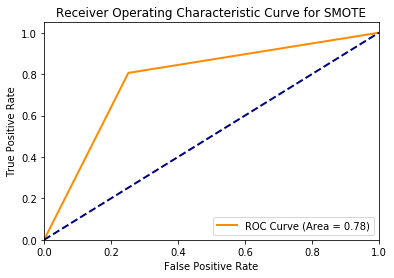

In [289]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC Curve (Area = %0.2f)' % smote_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve for SMOTE')
plt.legend(loc="lower right")